# Before you start
1. **Don't edit this file, make a copy first:**
  * Click on File -> Save a copy in Drive

2. Also do the following:
  * Click on Runtime -> Change runtime type -> Make sure hardware accelerator is set to GPU

# Goal of this notebook

- Intro and example to working with RNNs in Pytorch through a sentiment analysis problem (a type of NLP)


# Library Imports

In [1]:
%%capture

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
import time
import zipfile
import bz2
import re
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data as tdata

In [2]:
# Place kaggle.json where it needs to be

user = "xantha9"
key = "807bb77939717caa78d1b7d98701b569"
# Create directory
if '.kaggle' not in os.listdir('/content'):
    !mkdir /root/.kaggle
# Create file and write in kaggle user information
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

# Download kaggle data
!pip install kaggle
# Download data
!kaggle datasets download -d bittlingmayer/amazonreviews

 98% 481M/493M [00:20<00:00, 19.8MB/s]
100% 493M/493M [00:20<00:00, 25.1MB/s]


We are working with the Amazon review dataset, notice the same (data,label) concept is used to process our data.

Much like an image classification example.

In [3]:
def extract_zip():
  with zipfile.ZipFile('/content/amazonreviews.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')
    print("Zip file extracted")

In [4]:
unzip = True

if unzip:
  extract_zip()

Zip file extracted


In [5]:
def get_text_labels(file):
  labels = []
  texts = []
  for line in bz2.BZ2File(file):
    line = line.decode('utf-8')
    labels.append(int(line[9]) - 1)
    texts.append(line[10:].strip())
  return np.array(labels), texts

In [6]:
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z\s]')

def normalize_text(text):
  normalized_texts = []
  for line in text:
    line = line.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', line)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    normalized_texts.append(no_non_ascii)
  return normalized_texts

In [7]:
train_labels, train_text = get_text_labels('/content/test.ft.txt.bz2')

train_text = train_text[:5000]
train_labels = train_labels[:5000]

print(len(train_text)) #3.6M rows of data, takes awhile

5000


##Making sense of the data
We see the sentiment label (0 for poor review, 1 for good) matched with its review

There are non-Alphanumeric chars and upper/lower cases to clean

In [8]:
for i in range(3):
  print(train_labels[i], train_text[i])

1 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"
1 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs

In [9]:
train_text = normalize_text(train_text)

print(train_text[0])
print(train_text[60])

great cd  my lovely pat has one of the great voices of her generation  i have listened to this cd for years and i still love it  when i m in a good mood it makes me feel better  a bad mood just evaporates like sugar in the rain  this cd just oozes life  vocals are jusat stuunning and lyrics just kill  one of life s hidden gems  this is a desert isle cd in my book  why she never made it big is just beyond me  everytime i play this  no matter black  white  young  old  male  female everybody says one thing  who was that singing   
simply awesome   this was only my first cornwell novel and i m hooked  in the past few months i have managed to collect all of her books and i can t wait to dive into them  this summer will be a suspensful one for scarpetta and i 


In [10]:
TOP_COMMON = 5000

text_str = ' '.join(train_text)

#Counting the # of times a given word shows up in our reviews and sorting them by most common first
words = text_str.split()

word_count = Counter(words)

sorted_common = word_count.most_common(TOP_COMMON)

In [11]:
print(len(sorted_common))

print(sorted_common[4999])

5000
('valve', 5)


In [12]:
#Ordering the most common words & storing into a look up table
#0 will be the padding, 1 will be the missing words that are not in our most common
word2idx = {w:i+2 for i, (w,c) in enumerate(sorted_common)}

print(next(iter(word2idx)))
print(word2idx[next(iter(word2idx))])

the
2


In [13]:
common_words = [item[0] for item in sorted_common]

In [14]:
#Tokenizing our reviews into numbers based on the look up table
train_token = []
for line in train_text:
  temp_array = []
  token = [word2idx[word] if word in common_words else 1 for word in line.split()]
  train_token.append(token)

In [15]:
#Checking our tokens actually match the words using first and last number of the 1st list (1st review)
print(word2idx['great'])
print(word2idx['singing'])

35
814


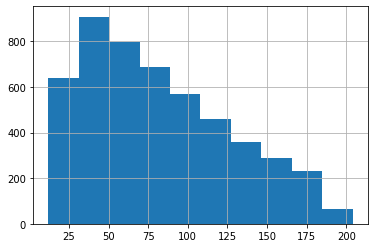

count    5000.000000
mean       82.190000
std        44.968771
min        12.000000
25%        45.000000
50%        74.000000
75%       114.000000
max       204.000000
dtype: float64

In [16]:
reviews_len = [len(x) for x in train_token]
pd.Series(reviews_len).hist()
plt.show()

pd.Series(reviews_len).describe()

In [17]:
mean = pd.Series(reviews_len).mean(0)
std = pd.Series(reviews_len).std(0)

MAX_LEN = int(mean + (2*std))
print(MAX_LEN)

172


In [50]:
def populate_tensor(token_list, max_len):
  '''
  Takes elements inside a list of lists and populates a Torch Tensor
  Limits the max # of elements in a row vector to max_len
  '''
  tensor = torch.zeros(len(token_list) ,max_len, dtype=torch.long)
  for i,x in enumerate(token_list):
    for j,elem in enumerate(x[:max_len]):
      tensor[i,j] = elem
  
  return tensor

In [51]:
train_tensor = populate_tensor(train_token, MAX_LEN)

print(train_tensor[1])
print(train_tensor.dtype)

tensor([  27,    8,    2,   86,  301,  119, 4772,   13,    5,  301,    3,  149,
          22,   68,  233,  898,    2,  319,   12,    3,   23,   63,  503,    5,
         254, 2942,    8,    2,  301,    2,  119,    3,  320,  612,    2, 1079,
           6,    1,    1,   90,   14,   35,   25,   69, 1616,   47,    6,  388,
           2,  969,    4,    7, 1967,   27,    8,   24,  265,  657,   52,   10,
          41,  899,  943,    8,  244, 1679,    4, 1220,  153,  164,  557,    4,
         399,  551,    3,  359,   34,   25,   52,   17,   18,   84,   94,    8,
         164, 2439,    8,  153,   11,   24,   79,  267,  301, 4772,    3,  171,
        1080,   12,   27,    8,    2,  153,  137,    5, 4773, 2076,   51,  838,
        1818,    6,   24,  749,   20,   94, 4259,   24,   27, 1260,   43,    9,
         969,   10,   12,   38,  142, 1261,    1,  613,   11,   94,    8,    2,
         153,   90,    3,  138, 2179,   19,   71,   32,  164, 1364,   22,  826,
           3,   50,  122,  944,    2,  3

In [52]:
frac_len = int(len(train_token)*0.8)

train_x, valid_x = torch.split(train_tensor, frac_len)
train_y, valid_y = torch.split(torch.from_numpy(train_labels), frac_len)

train_set = tdata.TensorDataset(train_x, train_y)
valid_set = tdata.TensorDataset(valid_x, valid_y)

In [53]:
BATCH_SIZE = 128

train_loader = tdata.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = tdata.DataLoader(valid_set, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [54]:
sample_x, sample_y = next(iter(train_loader))

print(f"Sample input: {sample_x}")
print(f"Sample input size: {sample_x.shape}")
print(f"Sample target: {sample_y}")
print(f"Sample target size: {sample_y.shape}")

Sample input: tensor([[   3,  242,    9,  ...,    0,    0,    0],
        [  33,  126,    1,  ...,    0,    0,    0],
        [ 883,    3,  381,  ...,    0,    0,    0],
        ...,
        [4906,    8,    2,  ...,    0,    0,    0],
        [  35,  126,   39,  ...,    0,    0,    0],
        [   2, 3343,   10,  ...,    0,    0,    0]])
Sample input size: torch.Size([128, 172])
Sample target: tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0])
Sample target size: torch.Size([128])


##Working with Custom RNN / LSTM models
This is the crux of the workshop, using the class of NNs called RNNs. The same concept can be applied to GRUs with a slight change to the parameters; 

RNN layers will output the (output state,hidden state) tuple.

Output is the concat of hidden states from every time step, hidden state is the final hidden state

Notice for LSTMs, the implementation allows for multiple layers to be stacked on top of another (More on the lecture)
and a probability for the forget gate

In [87]:
class CustomRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(CustomRNN, self).__init__()

        self.embed = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim) #Add num_layers, bidirectional, dropout etc. parameters to further experiment!
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
      
    def forward(self, token):
      print(token.shape) #[128,172]
      token = token.permute(1,0)
      print(token.shape) #[172,128]
      embedded = self.embed(token)
      print(embedded.shape) #[172,128,6000]
      rnn_out, hidden = self.rnn(embedded)
      print(hidden.shape) #[1,128,256]
      hidden = torch.squeeze(hidden, 0)
      linear_out = self.fc(hidden) #input[128,256] output [128,1]
      print(linear_out.shape)
      out_long = self.sig(linear_out)
      out_long = torch.squeeze(out_long,1)
      #output = out_long.float()
      #print(output.shape)
      #print(output.dtype)
      #return output
      return out_long

In [56]:
#Instatiating the GPU
torch.cuda.empty_cache()
cudnn.benchmark = False  # Optimise for hardware
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [88]:
lr = 1e-3
input_dim = len(word2idx) + 2
embedding_dim = 6000 #Size of dense word vectors, a hyperparam
hidden_dim = 256 #Size of the hidden states, generally linearly dependent on the size of the input data, complexity of task; A key hyperparameter in RNNs
output_dim = 1 #2 classes of output values between 0 and 1

model = CustomRNN(input_dim = input_dim, embedding_dim = embedding_dim, hidden_dim = hidden_dim, output_dim = output_dim)
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [58]:
model

CustomRNN(
  (embed): Embedding(5002, 6000)
  (rnn): RNN(6000, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

# The Training & Validation Functions

In [96]:
def train(model, iterator, loss_fn, optimizer, device):
    model.train() # puts the model in training mode
    running_loss = 0

    for tokens, labels in iterator: # loops through training data
      tokens, labels = tokens.to(device), labels.to(device)
      optimizer.zero_grad() # clear the gradients in model parameters
      outputs = model(tokens)

      loss = loss_fn(outputs.long(), labels) # calculate loss

      loss.backward() # calculates gradient w.r.t to loss for all parameters in model that have requires_grad=True
      optimizer.step() # iterate over all parameters in the model with requires_grad=True and update their weights.

      running_loss += loss.item() # sum total loss in current epoch for print later

    return running_loss/len(iterator) # returns the total training loss for the epoch

In [97]:
@torch.no_grad() #Function decorator, wraps validation inside no_grad
def validation(model, iterator, loss_fn, device):
    model.eval() # puts the model in eval mode, tells embedded layers etc to behave in eval mode
    running_loss = 0
    running_acc = 0
    correct = 0
    total = 0
    
    for tokens, labels in iterator:
      tokens, labels = tokens.to(device), labels.to(device)
      outputs= model(tokens) # passes image to the model, and gets a ouput which is the class probability prediction

      val_loss = loss_fn(outputs.long(), labels) # calculates val_loss from model predictions and true labels
      running_loss += val_loss.item()

      outputs = outputs.round()
      total += len(labels)

      correct += (outputs == labels).sum().item() #compare the output sentiment to labels
        
    return running_loss/len(iterator), correct/total # return loss value, accuracy

# Training

Try out different hidden state sizes and layers and observe the time taken

In [ ]:
total_epoch = 100
for epoch in range(total_epoch):
  start_time = time.clock()
  train_loss = train(model, train_loader, criterion, optimizer, device)
  val_loss, accuracy = validation(model, valid_loader, criterion, device)
  end_time = time.clock()
  print(f"Epoch: {epoch+1}/{total_epoch}, Training Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {accuracy}, Time taken: {end_time-start_time}")
  print('-' * 20)

print("Finished Training")